Setting Up Environment

In [95]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 9.0 MB/s eta 0:00:00 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [119]:
import pandas as pd
from datetime import datetime
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from collections import Counter
import pprint
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/81b211c5-4d1a-434f-99b7-
[nltk_data]     15559ab064ae/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/81b211c5-4d1a-434f-99b7-
[nltk_data]     15559ab064ae/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Load data
df_posts = pd.read_csv('cleaned_reddit_posts.csv')
df_comments = pd.read_csv('cleaned_reddit_comments.csv')

Topic Modeling 

In [6]:
# fill nulls with blanks
df_comments['cleaned_text'] = df_comments['cleaned_text'].fillna('')

In [49]:
# custom stopwords to ensure topic quality
extra_stopwords = {
    'have', 'has', 'had', 'would', 'could', 'should', 'the', 'to', 'of', 
    'in', 'on', 'is', 'it', 'be', 'was', 'for', 'with', 'that', 'not', 'are',
    'also', 'look', 'help', 'just', 'even', 'like', 'get', 'thing', 'look',
    'still', 'know', 'say', 'one', 'go', 'us', 'see', 'want', 'make', 'oh',
    'think', 'would', 'could', 'im', 'dont', 'didnt', 'got', 'really', 'youre',
    'something', 'v', 'aave', 'fran', 'th', 'eipper', 'york', 'look',
    'rodney', 'reed', 'case', 'rr', 'ive', 'say', 'two', 'page', 'list',
    'thanks', 'thank'
}
custom_stopwords = set(stopwords.words('english')).union(extra_stopwords)

In [ ]:
lemmatizer = WordNetLemmatizer()

In [50]:
def preprocess(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in custom_stopwords]
    return tokens

In [51]:
# preprocess text 
df_posts['tokens'] = df_posts['cleaned_text'].apply(preprocess)
df_comments['tokens'] = df_comments['cleaned_text'].apply(preprocess)

In [52]:
# create a dictionary and a corpus
# posts
dictionary_posts = corpora.Dictionary(df_posts['tokens'])
corpus_posts = [dictionary_posts.doc2bow(text) for text in df_posts['tokens']]

# comments
dictionary_comments = corpora.Dictionary(df_comments['tokens'])
corpus_comments = [dictionary_comments.doc2bow(text) for text in df_comments['tokens']]

In [46]:
# build LDA model for posts
lda_posts = LdaModel(corpus_posts,
                     num_topics=4, 
                     id2word=dictionary_posts,
                     passes=40
                    )


# print the topics
topics_posts = lda_posts.print_topics(num_words=10)
for topic in topics_posts:
    print(topic)

(0, '0.015*"season" + 0.013*"murder" + 0.009*"story" + 0.008*"look" + 0.008*"death" + 0.006*"year" + 0.006*"podcast" + 0.006*"found" + 0.005*"crime" + 0.005*"man"')
(1, '0.009*"dna" + 0.009*"stites" + 0.009*"stacey" + 0.008*"murder" + 0.008*"evidence" + 0.007*"found" + 0.007*"fennell" + 0.006*"reed" + 0.005*"police" + 0.005*"texas"')
(2, '0.023*"texas" + 0.023*"court" + 0.020*"death" + 0.019*"row" + 0.017*"supreme" + 0.016*"dna" + 0.014*"testing" + 0.013*"inmate" + 0.012*"new" + 0.010*"innocence"')
(3, '0.008*"producer" + 0.008*"kim" + 0.007*"child" + 0.006*"court" + 0.006*"stream" + 0.006*"state" + 0.006*"kris" + 0.005*"time" + 0.005*"khloe" + 0.005*"family"')


In [122]:
# check coherence score to ensure topics make sense.
coherence_model_lda_posts = CoherenceModel(model=lda_posts, texts=df_posts['tokens'], dictionary=dictionary_posts, coherence='c_v')
posts_coherence_score = coherence_model_lda_posts.get_coherence()
print(f'Coherence Score: {posts_coherence_score}')

Coherence Score: 0.4921659000884037


In [63]:
# build LDA model for comments
lda_comments = LdaModel(corpus_comments, 
                        num_topics=3, 
                        id2word=dictionary_comments,
                        passes=50
                       )

# display topics
topics_comments = lda_comments.print_topics(num_words=10)
for topic in topics_comments:
    print(topic)

(0,
 '0.034*"dna" + 0.019*"reed" + 0.015*"stacey" + 0.014*"evidence" + 0.013*"found" + 0.013*"murder" + 0.012*"testing" + 0.011*"stites" + 0.011*"staceys" + 0.010*"woman"')

(1,
 '0.009*"people" + 0.007*"evidence" + 0.007*"trial" + 0.006*"death" + 0.005*"court" + 0.005*"time" + 0.005*"crime" + 0.004*"murder" + 0.004*"year" + 0.004*"new"')

(2,
 '0.022*"raped" + 0.018*"rape" + 0.015*"murder" + 0.014*"home" + 0.014*"schlueter" + 0.014*"dna" + 0.013*"kit" + 0.013*"rivas" + 0.013*"foreign" + 0.013*"rivass"')

In [123]:
# check coherence score to ensure topics make sense.  
coherence_model_lda_comments = CoherenceModel(model=lda_comments, texts=df_comments['tokens'], dictionary=dictionary_comments, coherence='c_v')
comments_coherence_score = coherence_model_lda_comments.get_coherence()
print(f'Coherence Score: {comments_coherence_score}')

Coherence Score: 0.5488530443009676


In [70]:
# function to label dominate topics
def get_dominant_topic(lda_model, corpus):
    return [max(lda_model[doc], key=lambda x: x[1])[0] if lda_model[doc] else None for doc in corpus]

# create column for topic numbers
df_posts['topic_num'] = get_dominant_topic(lda_posts, corpus_posts)
df_comments['topic_num'] = get_dominant_topic(lda_comments, corpus_comments)

In [ ]:
# save to csv
df_posts.to_csv('rodney_reed_topic_posts.csv', index=False)
df_comments.to_csv('rodney_reed_topic_comments.csv', index=False)

Assign Names and Colors for Visualizations

In [ ]:
# post topic names and colors
topic_names_posts = {
    0: 'True Crime',
    1: 'Case Details',
    2: 'Legal Proceedings',
    3: 'Celebrity Involvement'
}

custom_colors_posts = {
    0: '#a29a9a',   
    1: '#92b281',  
    2: '#f46530',
    3: '#1865ab'
}

In [ ]:
# comment topic names and colors
topic_names_comments = {
    0: "DNA Evidence",
    1: "Legal Discussion",
    2: "Sexual Assault Allegations"
}

custom_colors_comments = {
    0: "#92b281",   
    1: "#f46530",  
    2: "#1865ab"  
}

Topics Trends Over Time For Posts and Comments

In [72]:
# create month column
df_posts['date'] = pd.to_datetime(df_posts['date'], errors='coerce')
df_comments['date'] = pd.to_datetime(df_comments['date'], errors='coerce')

df_posts['month'] = df_posts['date'].dt.to_period('M')
df_comments['month'] = df_comments['date'].dt.to_period('M')

# count topic frequencies by month
topic_trend_posts = df_posts.groupby(['month', 'topic_num']).size().unstack(fill_value=0)
topic_trend_comments = df_comments.groupby(['month', 'topic_num']).size().unstack(fill_value=0)

# set index
topic_trend_posts.index = topic_trend_posts.index.to_timestamp()
topic_trend_comments.index = topic_trend_comments.index.to_timestamp()

In [143]:
# post topics over time
display(topic_trend_posts)

topic_num,0,1,2,3
month,,,,
2019-11-01,1,2,2,6
2019-12-01,0,3,0,0
2020-02-01,0,0,7,0
2020-03-01,1,0,1,0
2020-04-01,0,1,0,0
2020-05-01,0,2,0,1
2020-07-01,0,2,1,1
2020-12-01,0,1,0,0
2021-01-01,0,1,0,1


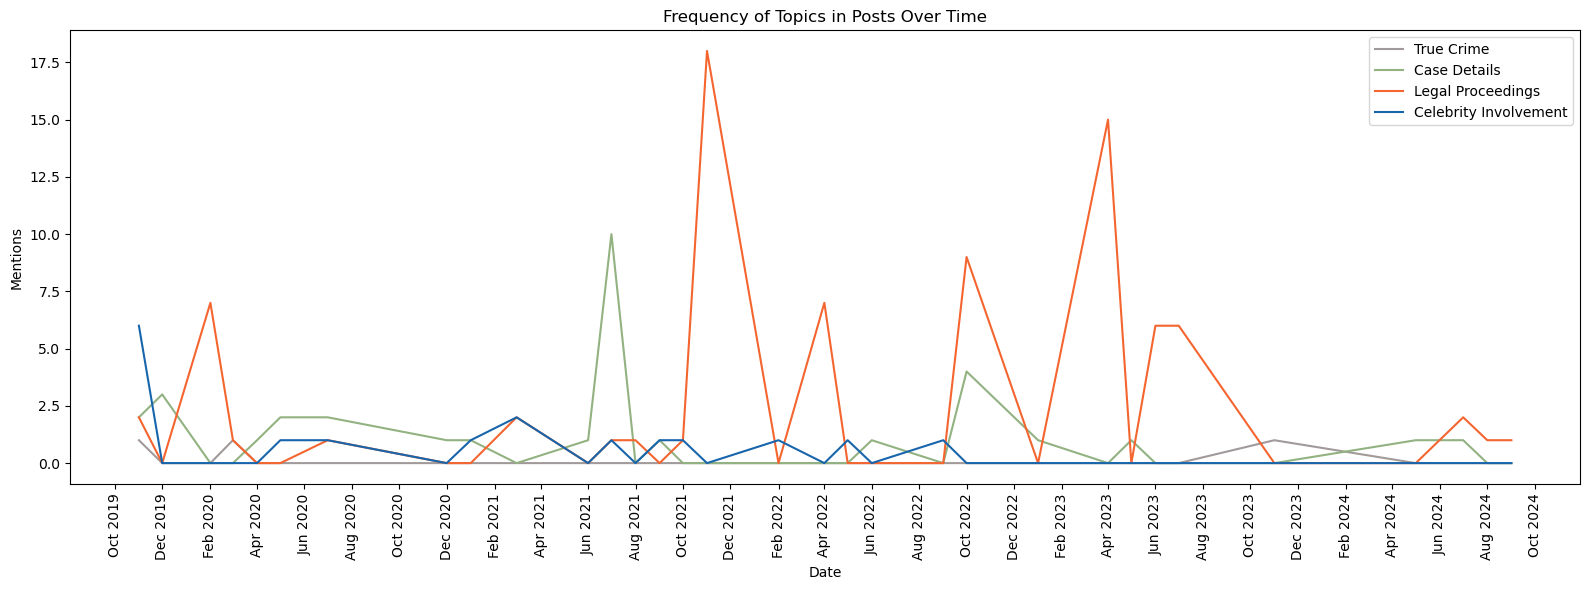

In [197]:
# Post Topics Over Time
plt.figure(figsize=(16, 6))
for topic_id in topic_trend_posts.columns:
    plt.plot(
        topic_trend_posts.index,
        topic_trend_posts[topic_id],
        label=topic_names_posts.get(topic_id, f'Topic {topic_id}'),
        color=custom_colors_posts.get(topic_id)
    )

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Frequency of Topics in Posts Over Time')
plt.xlabel('Date')
plt.ylabel('Mentions')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [144]:
# comment topics over time
display(topic_trend_comments)

topic_num,0,1,2
month,,,
2019-11-01,74,100,14
2019-12-01,2,38,2
2020-01-01,0,5,1
2020-02-01,2,5,0
2020-03-01,3,16,0
2020-05-01,5,52,0
2020-07-01,1,33,0
2020-08-01,0,4,0
2020-11-01,0,3,0


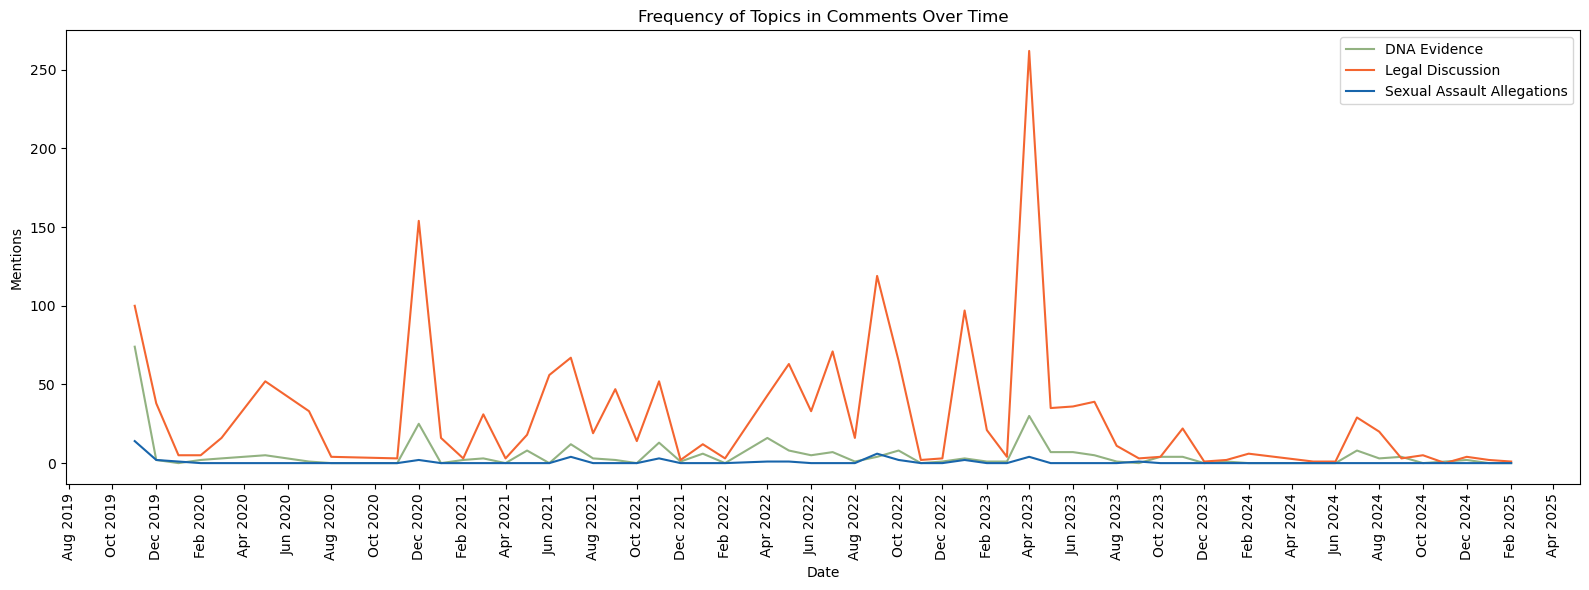

In [198]:
# Comment Topics Over Time
plt.figure(figsize=(16, 6))
for topic_id in topic_trend_comments.columns:
    plt.plot(
        topic_trend_comments.index,
        topic_trend_comments[topic_id],
        label=topic_names_comments.get(topic_id, f'Topic {topic_id}'),
        color=custom_colors_comments.get(topic_id)
    )

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Frequency of Topics in Comments Over Time')
plt.xlabel('Date')
plt.ylabel('Mentions')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Sentiment by Topics 

In [185]:
# load sentiment data
post_sentiment = pd.read_csv('sentiment_reddit_posts.csv')
comment_sentiment = pd.read_csv('sentiment_reddit_comments.csv')

# copy sentiment column
df_posts['sentiment'] = post_sentiment['sentiment']
df_comments['sentiment'] = comment_sentiment['sentiment']

# copy sentiment labels
df_posts['sentiment_label'] = post_sentiment['sentiment_label']
df_comments['sentiment_label'] = comment_sentiment['sentiment_label']

Sentiment of Post Topics

In [191]:
# sentiment label counts per topic
post_topic_sentiment_labels = df_posts.groupby('topic_num')['sentiment_label'].value_counts()
display(post_topic_sentiment_labels)

topic_num  sentiment_label
0          Negative            2
           Neutral             1
1          Negative           23
           Neutral             7
           Positive            3
2          Negative           51
           Positive           27
           Neutral             3
3          Positive           10
           Negative            6
           Neutral             1
Name: count, dtype: int64

In [89]:
# sentiment statistics by topics
topic_sentiment_stats_posts = df_posts.groupby('topic_num')['sentiment'].describe()
display(topic_sentiment_stats_posts)

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
0,3.0,-0.628933,0.547605,-1.0000,-0.9434,-0.8868,-0.4434,0.0000
1,33.0,-0.412636,0.496169,-0.9999,-0.8196,-0.4588,0.0000,0.8602
2,81.0,-0.126841,0.495173,-0.9513,-0.5994,-0.0772,0.2500,0.9352
3,17.0,0.288859,0.708100,-0.9997,-0.4019,0.4404,0.9199,0.9997


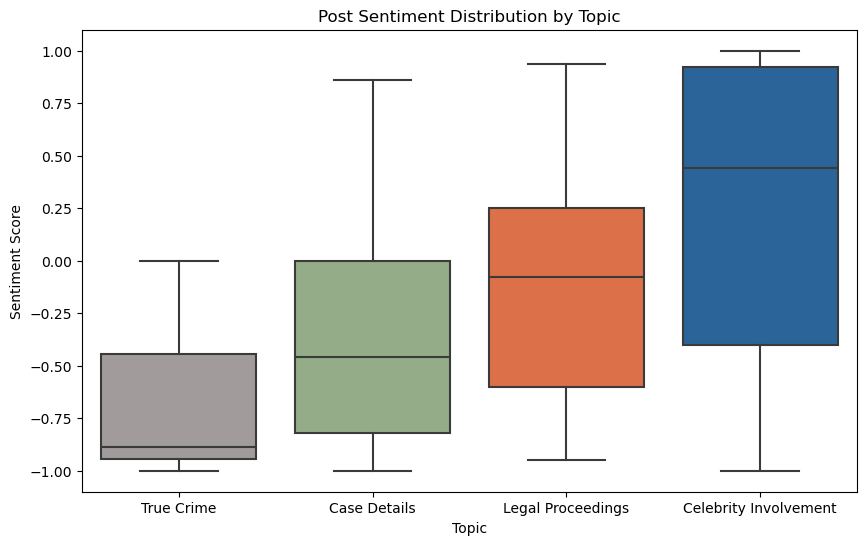

In [199]:
# Post Sentiment Distribution by Topic
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic_num', 
            y='sentiment', 
            data=df_posts,
            palette=custom_colors_posts
           )
ax = plt.gca()
ax.set_xticklabels([topic_names_posts.get(int(label.get_text()), label.get_text()) 
                    for label in ax.get_xticklabels()])
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
plt.title('Post Sentiment Distribution by Topic')
plt.show()

In [96]:
# variance in sentiment by topic
sentiment_variance_posts = df_posts.groupby('topic_num')['sentiment'].var()
print(sentiment_variance_posts)

topic
0    0.299871
1    0.246184
2    0.245196
3    0.501405
Name: sentiment, dtype: float64

In [97]:
# number of posts with extreme sentiment
extreme_posts = df_posts[df_posts['sentiment'].abs() > 0.75]
polarizing_topic_count_posts = extreme_posts.groupby('topic_num').size()
print(polarizing_topic_count_posts)

topic
0     2
1    12
2    10
3     8
dtype: int64


Sentiment of Comment Topics

In [192]:
# sentiment label counts per topic
comment_topic_sentiment_labels = df_comments.groupby('topic_num')['sentiment_label'].value_counts()
display(comment_topic_sentiment_labels)

topic_num  sentiment_label
0          Negative           188
           Positive            63
           Neutral             43
1          Negative           973
           Positive           607
           Neutral            197
2          Negative            28
           Neutral              8
           Positive             7
Name: count, dtype: int64

In [90]:
# sentiment statistics by topic
topic_sentiment_stats_comments = df_comments.groupby('topic_num')['sentiment'].describe()
display(topic_sentiment_stats_comments)

,count,mean,std,min,25%,50%,75%,max
topic,,,,,,,,
0,294.0,-0.376614,0.561864,-0.9991,-0.9213,-0.52555,0.0000,0.9722
1,1777.0,-0.186337,0.613801,-0.9999,-0.7875,-0.22630,0.3612,0.9929
2,43.0,-0.450156,0.579402,-0.9998,-0.9986,-0.68080,0.0000,0.7003


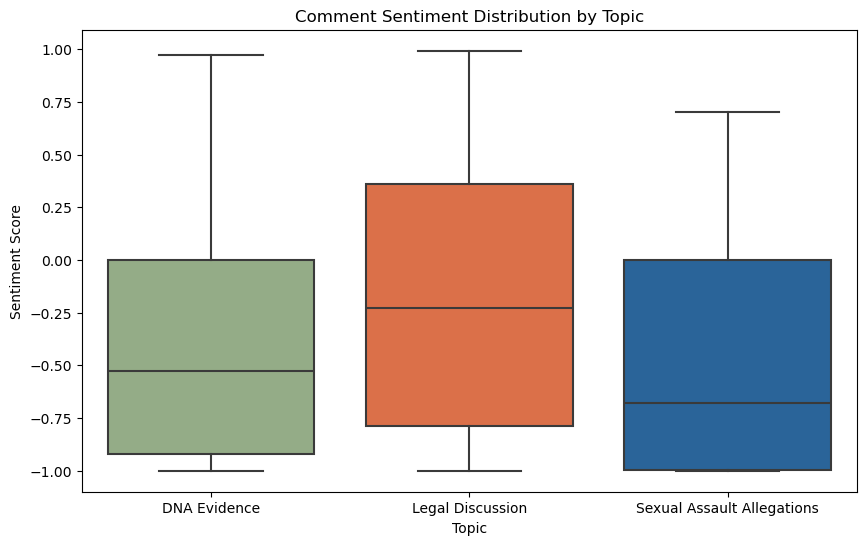

In [200]:
# Comment Sentiment Distribution by Topic
plt.figure(figsize=(10, 6))
sns.boxplot(x='topic_num', 
            y='sentiment', 
            data=df_comments,
            palette=custom_colors_comments
           )
ax = plt.gca()
ax.set_xticklabels([topic_names_comments.get(int(label.get_text()), label.get_text()) 
                    for label in ax.get_xticklabels()])
plt.xlabel('Topic')
plt.ylabel('Sentiment Score')
plt.title('Comment Sentiment Distribution by Topic')
plt.show()

In [95]:
# variance in sentiment by topic
sentiment_variance_comments = df_comments.groupby('topic_num')['sentiment'].var()
display(sentiment_variance_comments)

topic
0    0.315692
1    0.376752
2    0.335706
Name: sentiment, dtype: float64

In [98]:
# number of comments with extreme sentiments 
extreme_comments = df_comments[df_comments['sentiment'].abs() > 0.75]
polarizing_topic_count_comments = extreme_comments.groupby('topic_num').size()
print(polarizing_topic_count_comments)

topic
0    120
1    640
2     19
dtype: int64


Engagement by Topics

Post Engagement by Topics

In [164]:
# post score statistics by topic
post_score_by_topic = df_posts.groupby('topic_num')['score'].agg(['mean', 'std']).sort_values('mean', ascending=False)
print(post_score_by_topic)

                 mean         std
topic_num                        
0          288.666667  488.729305
3          102.058824  347.959852
2           67.185185  409.655712
1           20.757576   38.820927


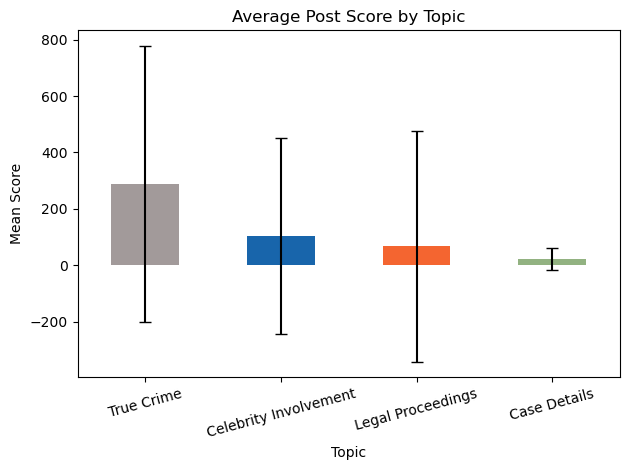

In [201]:
# Average Post Score by Topic
color_list = [custom_colors_posts.get(topic) for topic in post_score_by_topic.index]
post_score_by_topic['mean'].plot(kind='bar', 
                                 yerr=post_score_by_topic['std'], 
                                 capsize=4,
                                 color=color_list
                                )
ax = plt.gca()
ax.set_xticklabels([topic_names_posts.get(int(label.get_text()), label.get_text()) 
                    for label in ax.get_xticklabels()])
plt.xticks(rotation=15)
plt.title('Average Post Score by Topic')
plt.ylabel('Mean Score')
plt.xlabel('Topic')
plt.tight_layout()
plt.show()

In [168]:
# number of comments on post statistics by topic
post_comment_by_topic = df_posts.groupby('topic_num')['num_comments'].agg(['mean', 'std']).sort_values('mean', ascending=False)
print(post_comment_by_topic)

                mean        std
topic_num                      
0          69.000000  79.774683
1          22.181818  50.594253
3          19.529412  36.927493
2          12.037037  30.548095


In [175]:
# top subreddits by topic
post_subreddit_counts = df_posts.groupby(['topic_num', 'subreddit']).size().reset_index(name='count')
post_topics_top_subreddits = post_subreddit_counts.sort_values(['topic_num', 'count'], ascending=[True, False]) \
                                 .groupby('topic_num').first().reset_index()
print(post_topics_top_subreddits)

   topic_num      subreddit  count
0          0      TrueCrime      1
1          1      BastropTX      9
2          2  AutoNewspaper     15
3          3         Austin      2


In [176]:
# top post per topics by number of comments
for topic in df_posts['topic_num'].unique():
    top = df_posts[df_posts['topic_num'] == topic].sort_values('num_comments', ascending=False).head(1)
    print(f"\n--- Top post for Topic {topic} ---")
    print(top['title'].values[0])


--- Top post for Topic 2 ---
Supreme Court Lets Rodney Reed, a Texas Death Row Inmate, Seek DNA Testing

--- Top post for Topic 1 ---
Kim Kardashian and other celebs believe Rodney Reed was wrongfully convicted for the murder of Stacey Stites. What do you think?

--- Top post for Topic 0 ---
List of True Crime Podcasts - one case per podcast/season - with descriptions

--- Top post for Topic 3 ---
Upcoming Supreme Court cases that could change America


In [127]:
# top post per topics by score
for topic in df_posts['topic_num'].unique():
    top = df_posts[df_posts['topic_num'] == topic].sort_values('score', ascending=False).head(1)
    print(f"\n--- Top post for Topic {topic} ---")
    print(top['title'].values[0])


--- Top post for Topic 2 ---
Supreme Court Lets Rodney Reed, a Texas Death Row Inmate, Seek DNA Testing

--- Top post for Topic 1 ---
Kim Kardashian and other celebs believe Rodney Reed was wrongfully convicted for the murder of Stacey Stites. What do you think?

--- Top post for Topic 0 ---
List of True Crime Podcasts - one case per podcast/season - with descriptions

--- Top post for Topic 3 ---
Upcoming Supreme Court cases that could change America


In [181]:
# top post per topics by sentiment
for topic in df_posts['topic_num'].unique():
    top = df_posts[df_posts['topic_num'] == topic].sort_values('sentiment', ascending=False).head(1)
    print(f"\n--- Top post for Topic {topic} ---")
    print(top['title'].values[0])


--- Top post for Topic 2 ---
Second Chance: Heroes vs Villains

--- Top post for Topic 1 ---
Granted writ

--- Top post for Topic 0 ---
Rodney Reed

--- Top post for Topic 3 ---
Konfidential KUWTK Producer Secrets - Season 18, Episode 5


In [137]:
# top words per topic over time
post_top_words = {}

for topic in df_posts['topic_num'].unique():
    topic_data = df_posts[df_posts['topic_num'] == topic]
    monthly_top_words = {}

    for month, group in topic_data.groupby('month'):
        word_counts = Counter([word for tokens in group['tokens'] for word in tokens])
        top_words = [word for word, _ in word_counts.most_common(5)]
        monthly_top_words[str(month)] = top_words

    post_top_words[topic] = monthly_top_words


display(post_top_words)

{2: {'2019-11': ['michael', 'baden', 'death', 'row', 'inmate'],
  '2020-02': ['supreme', 'court', 'appeal', 'wont', 'take'],
  '2020-03': ['please', 'sign', 'share', 'rodneyreed', 'innocent'],
  '2020-07': ['hero', 'villain', 'girl', 'natalie', 'christian'],
  '2021-03': ['remember', 'bastrop', 'mustve', 'texas', 'hearing'],
  '2021-07': ['lawyer', 'tell', 'judge', 'new', 'evidence'],
  '2021-08': ['emmajayne', 'magson', 'murderer', 'supporter', 'abuse'],
  '2021-10': ['recommendation', 'new', 'trial', 'expected', 'halloween'],
  '2021-11': ['judge', 'texas', 'new', 'trial', 'say'],
  '2022-04': ['supreme', 'court', 'hear', 'dna', 'murder'],
  '2022-10': ['dna', 'testing', 'supreme', 'court', 'texas'],
  '2023-04': ['dna', 'testing', 'supreme', 'court', 'texas'],
  '2023-06': ['texas', 'court', 'death', 'row', 'inmate'],
  '2023-07': ['dozen', 'witness', 'innocent', 'texas', 'court'],
  '2024-07': ['supreme', 'court', 'review', 'letdown', 'death'],
  '2024-08': ['cover', 'dr', 'phil', 

Comment Engagement by Topics

In [165]:
# comment score statistics by topics
comment_score_by_topic = df_comments.groupby('topic_num')['score'].agg(['mean', 'std']).sort_values('mean', ascending=False)
print(comment_score_by_topic)

                mean        std
topic_num                      
2          13.906977  34.411248
1           8.820484  41.792668
0           5.336735  13.153032


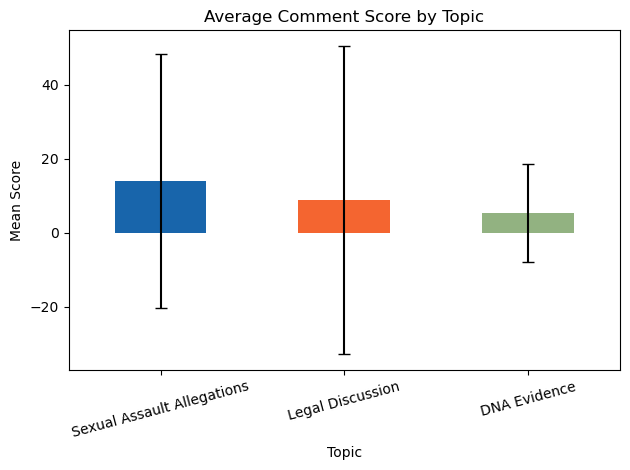

In [202]:
# Average Comment Score by Topic
color_list = [custom_colors_comments.get(topic) for topic in comment_engagement_by_topic.index]
comment_score_by_topic['mean'].plot(kind='bar', 
                                    yerr=comment_score_by_topic['std'], 
                                    capsize=4,
                                    color=color_list
                                   )
ax = plt.gca()
ax.set_xticklabels([topic_names_comments.get(int(label.get_text()), label.get_text()) 
                    for label in ax.get_xticklabels()])
plt.xticks(rotation=15)
plt.title('Average Comment Score by Topic')
plt.ylabel('Mean Score')
plt.xlabel('Topic')
plt.tight_layout()
plt.show()

In [183]:
# top comments per topics by sentiment
for topic in df_comments['topic_num'].unique():
    top = df_comments[df_comments['topic_num'] == topic].sort_values('sentiment', ascending=False).head(1)
    print(f"\n--- Top post for Topic {topic} ---")
    print(top['body'].values[0])


--- Top post for Topic 1 ---
I'm sorry, but although I agree OJ was guilty, Chauvin's trial was as fair as anyone elses.  I watched alot of it and listened while at work and he was not slighted in his defense.  He may have been convicted in the public eye before the trial began, but that was because the video evidence was pretty hard to overcome.  How can he explain away his actions from that day?  There is no logical reason to manhandle someone that way who is not putting up a fight, and is begging to be allowed to breathe.

I look at it like this.  A person in a position of power, whether a cop, president, or preacher, has a higher level of scrutiny and must live up to their position.  No one is perfect, but if you choose to be a preacher, then you have to try your best to live as God has instructed and when you slip, repent and ask forgiveness.  If you are president, then you "should" act with integrity and as a leader for your people.

When a cop is tasked with keeping people safe

In [130]:
# top comment per topic by score
for topic in df_comments['topic_num'].unique():
    top = df_comments[df_comments['topic_num'] == topic].sort_values('score', ascending=False).head(1)
    print(f"\n--- Top comments for Topic {topic} ---")
    print(top['body'].values[0])


--- Top comments for Topic 1 ---
> In a separate dissent, Justice Clarence Thomas said that there was no doubt of Mr. Reed’s guilt and that federal courts had no role to play in ensuring his access to DNA evidence. Justice Thomas appeared to urge officials in Texas to execute Mr. Reed even while his efforts to obtain the DNA evidence moved forward.

Sometimes it feels like Clarence is trying too hard.

--- Top comments for Topic 0 ---
I’m late to the party, but here’s my thoughts (copied from a previous write up of mine):

There is no new evidence in the Reed case. A couple people coming forward after TWENTY YEARS of silence isn’t valid evidence. The defense that it was consensual was presented at his original trial, and the jury didn’t find it viable. He has NEVER testified at trial about a consensual relationship. 

What we do know, and what has already been presented to the courts:

Stacey was wearing her HEB shirt, work shoes, work pants and name tag when she was abducted, raped a

In [138]:
# top words in comments over time
comment_top_words_over_time = {}

for topic in df_comments['topic_num'].unique():
    topic_data_comments = df_comments[df_comments['topic_num'] == topic]
    monthly_top_words_comments = {}

    for month, group in topic_data_comments.groupby('month'):
        word_counts = Counter([word for tokens in group['tokens'] for word in tokens])
        top_words = [word for word, _ in word_counts.most_common(5)]
        monthly_top_words_comments[str(month)] = top_words

    comment_top_words_over_time[topic] = monthly_top_words_comments


display(comment_top_words_over_time)

{1: {'2019-11': ['murder', 'people', 'great', 'trial', 'new'],
  '2019-12': ['murder', 'year', 'crime', 'show', 'podcasts'],
  '2020-01': ['american', 'podcast', 'called', 'unravel', 'true'],
  '2020-02': ['instagram', 'truecrimepodcasts', 'every', 'update', 'wanted'],
  '2020-03': ['snow', 'time', 'confession', 'well', 'reed'],
  '2020-05': ['stacey', 'stites', 'witness', 'evidence', 'murder'],
  '2020-07': ['found', 'dna', 'v', 'trial', 'stites'],
  '2020-08': ['court', 'evidence', 'retrial', 'new', 'witness'],
  '2020-11': ['care', 'reed', 'right', 'denies', 'happened'],
  '2020-12': ['evidence', 'death', 'trial', 'people', 'rape'],
  '2021-01': ['people', 'black', 'white', 'lot', 'drag'],
  '2021-02': ['time', 'evidence', 'son', 'special', 'said'],
  '2021-03': ['dna', 'evidence', 'stites', 'found', 'bastrop'],
  '2021-04': ['rape', 'reed', 'allegation', 'prior', 'murder'],
  '2021-05': ['truck', 'found', 'stacey', 'drug', 'evidence'],
  '2021-06': ['trial', 'jury', 'family', 'guil

Wordclouds for Topics of Post and Comments

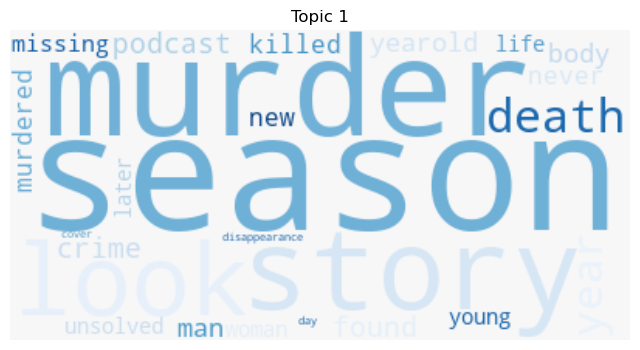

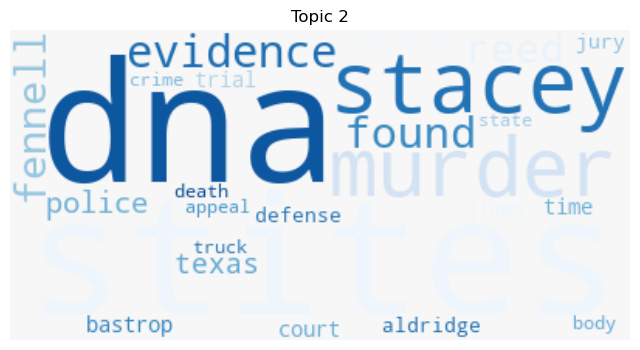

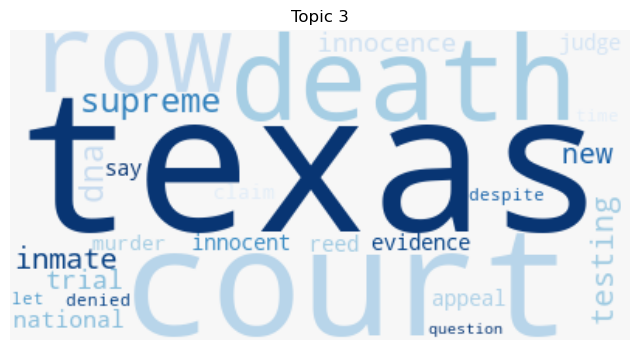

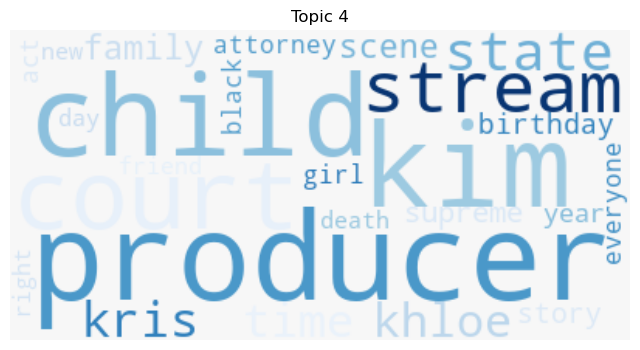

In [68]:
# WordCloud by Post Topics
for t in range(lda_posts.num_topics):
    plt.figure(figsize=(8, 8))
    wordcloud = WordCloud(background_color='#f7f7f7', colormap='Blues').generate_from_frequencies(dict(lda_posts.show_topic(t, 25)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Topic {t+1}')
    plt.axis('off')
    plt.show()

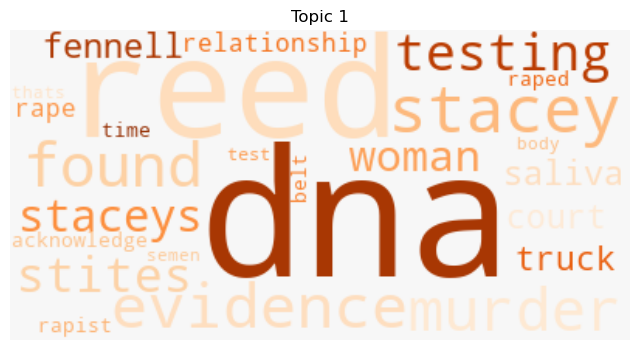

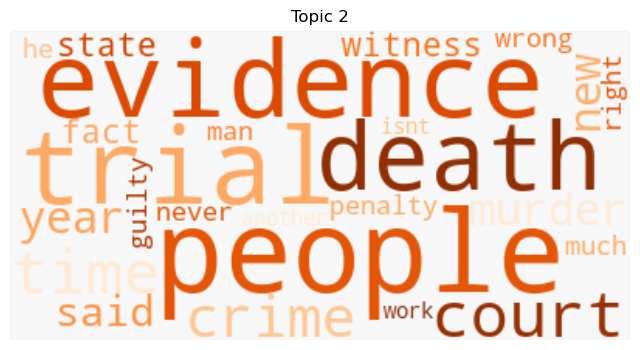

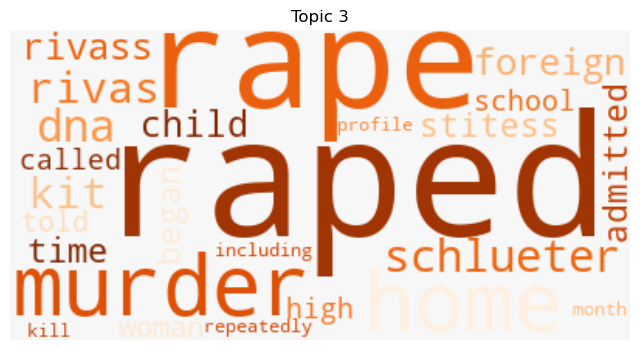

In [78]:
# WordCloud by Comment Topics
for t in range(lda_comments.num_topics):
    plt.figure(figsize=(8, 8))
    wordcloud_comments = WordCloud(background_color='#f7f7f7', colormap='Oranges').generate_from_frequencies(dict(lda_comments.show_topic(t, 25)))
    plt.imshow(wordcloud_comments, interpolation='bilinear')
    plt.title(f'Topic {t+1}')
    plt.axis('off')
    plt.show()